In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import flatbuffers
import importlib
import pydot
from tensorflow_dataloader import * 
from focal_loss import BinaryFocalLoss

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.8.0


672 images loaded


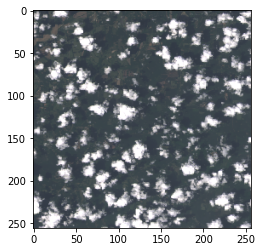

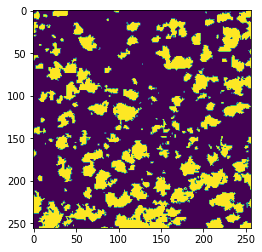

In [2]:
trainset = CloudDataset(ROOT_PATH, TRAINSET_PATH)
testset = CloudDataset(ROOT_PATH, TESTSET_PATH)

dataset_length = len(trainset)
print(f"{dataset_length} images loaded")
d = trainset[2]
img = d['img']
plt.imshow(img)
plt.show()
plt.imshow(d['ref'])
plt.show()

In [3]:
def down_conv(in_channels, out_channels):
    layers = tf.keras.Sequential()
    layers.add(tf.keras.layers.Conv2D(filters=out_channels, kernel_size=3,padding='SAME'))
    layers.add(tf.keras.layers.BatchNormalization())
    layers.add(tf.keras.layers.LeakyReLU(alpha=0.1))
    return layers

def downscale(channels):
    return tf.keras.layers.MaxPool2D(pool_size=2)

def upscale(channels):
    return tf.keras.layers.UpSampling2D(size=2)

def up_conv(in_channels, out_channels):
    layers = tf.keras.Sequential()
    layers.add(tf.keras.layers.Conv2D(filters=out_channels, kernel_size=3,padding='SAME'))
    layers.add(tf.keras.layers.BatchNormalization())
    layers.add(tf.keras.layers.LeakyReLU(alpha=0.1))
    return layers

class UNet(tf.keras.Model):
    def __init__(self):
        super().__init__()
        # define all the layers here
        self.dc1 = down_conv(3, 36)
        self.dc2 = down_conv(36, 72)
        self.dc3 = down_conv(72, 144)
        self.dc4 = down_conv(144, 288)

        self.ds1 = downscale(36)
        self.ds2 = downscale(72)
        self.ds3 = downscale(144)
        self.ds4 = downscale(288)
        
        self.uc1 = up_conv(288 * 2, 144 )
        self.uc2 = up_conv(144 * 2, 72 )
        self.uc3 = up_conv(72 * 2, 36)
        self.uc4 = up_conv(36 * 2, 12)

        self.us1 = upscale(288 * 2)
        self.us2 = upscale(144 * 2)
        self.us3 = upscale(72 * 2)
        self.us4 = upscale(36 * 2)
        
        # todo - redo these in tensorflow style
        self.bottleneck = tf.keras.Sequential([
            tf.keras.layers.Conv2D(288, kernel_size=3,padding='SAME'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(alpha=0.1),
            tf.keras.layers.Conv2D(288, kernel_size=3,padding='SAME'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(alpha=0.1),
            tf.keras.layers.Conv2D(288, kernel_size=3,padding='SAME'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(alpha=0.1)
        ])
        
        self.outconv = tf.keras.Sequential([
            tf.keras.layers.Conv2D(1, kernel_size=1, padding='SAME'),
            tf.keras.layers.Activation('sigmoid')
        ])
        
    @tf.function(input_signature=[tf.TensorSpec(shape=[None,256,256,3], dtype=tf.float32)]) 
    def call(self, x):
        y1 = self.dc1(x)
        x1 = self.ds1(y1)
        
        y2 = self.dc2(x1)
        x2 = self.ds2(y2)
        
        y3 = self.dc3(x2)
        x3 = self.ds3(y3)
        
        y4 = self.dc4(x3)
        x4 = self.ds4(y4)
        
        y5 = self.bottleneck(x4)

        z4 = self.uc1(tf.concat((self.us1(y5), y4), 3))
        z3 = self.uc2(tf.concat((self.us2(z4), y3), 3))
        z2 = self.uc3(tf.concat((self.us3(z3), y2), 3))
        z1 = self.uc4(tf.concat((self.us4(z2), y1), 3))
        
        q = self.outconv(z1)
        return q

In [67]:
# build a model...
# first set up a loss

def weighted_cross_entropy(beta):
  def loss(y_true, y_pred):
    weight_a = beta * tf.cast(y_true, tf.float32)
    weight_b = 1 - tf.cast(y_true, tf.float32)
    
    o = (tf.math.log1p(tf.exp(-tf.abs(y_pred))) + tf.nn.relu(-y_pred)) * (weight_a + weight_b) + y_pred * weight_b 
    return tf.reduce_mean(o) + tf.reduce_sum((y_true[:] - y_pred[:]) ** 2)

  return loss

inputs = tf.keras.layers.Input(shape=(256, 256, 3))

model = UNet()
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)
model.compile(optimizer=optimizer, loss=BinaryFocalLoss(gamma=5),metrics=["mae", "acc"])

# imgs = [x['img'] for x in trainset]
# refs = [x['ref'] for x in trainset]
# do this the dumb way... sigh i fucking hate tensorflow
# trainset.images_list

BATCH_SIZE = 10
BUFFER_SIZE = 100

trainset_tf = tf.data.Dataset.from_tensor_slices(trainset.images_list)
trainset_tf = trainset_tf.map(CloudDataset.load_img)
trainset_tf = trainset_tf.shuffle(buffer_size=BUFFER_SIZE, seed=0)
# trainset_tf = trainset_tf.repeat()
trainset_tf = trainset_tf.batch(BATCH_SIZE)
trainset_tf = trainset_tf.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
# def load_image(img_name):

testset_tf = tf.data.Dataset.from_tensor_slices(testset.images_list)
testset_tf = testset_tf.map(CloudDataset.load_img_test)
testset_tf = testset_tf.batch(BATCH_SIZE)

model.build([1, 256, 256, 3])


    


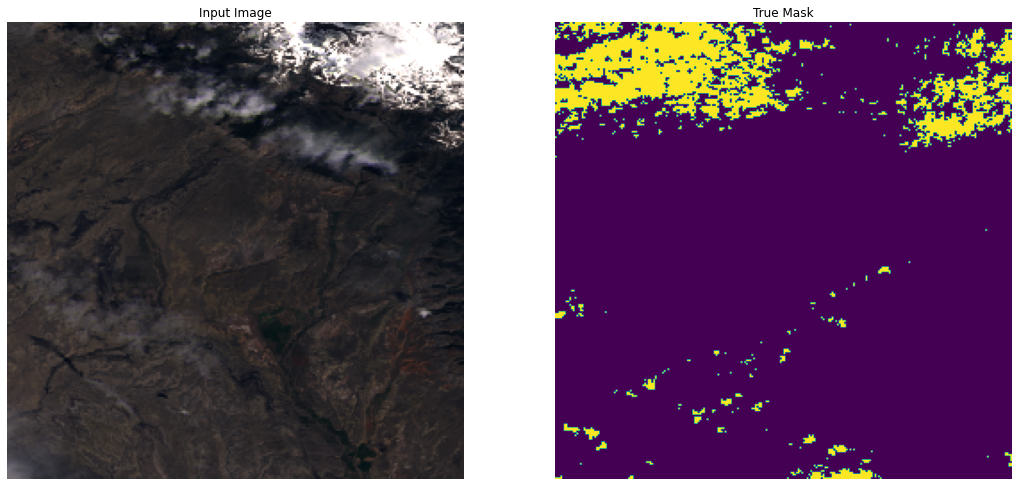

(10, 256, 256, 3)


In [68]:
# model.fit(trainset_tf, refs, epochs=5)
def display_sample(display_list):
    """Show side-by-side an input image,
    the ground truth and the prediction.
    """
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()
    
for image, mask in testset_tf.take(3):
    sample_image, sample_mask = image, mask

display_sample([sample_image[1], sample_mask[0]])
print(sample_image.shape)
# print(trainset_tf.shape)

(1, 256, 256, 1)


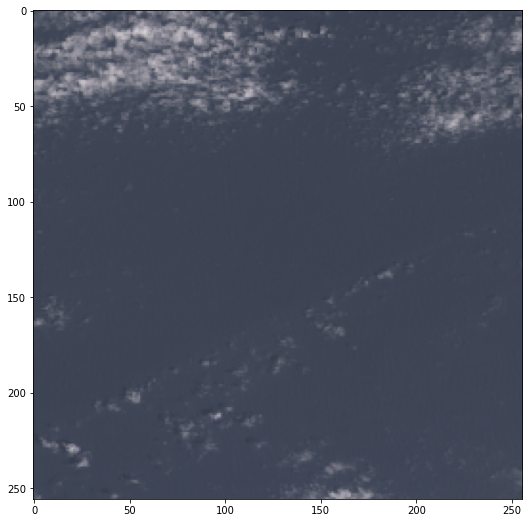

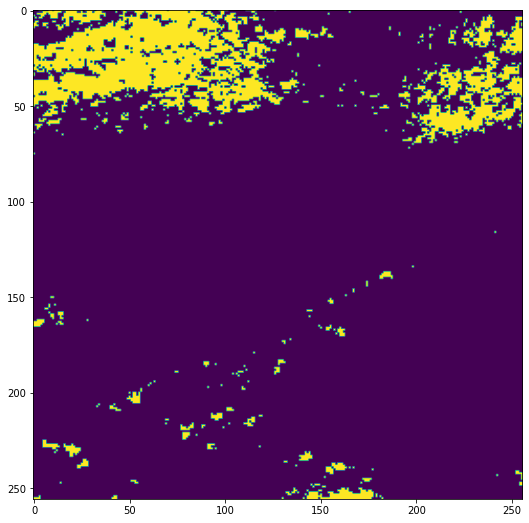

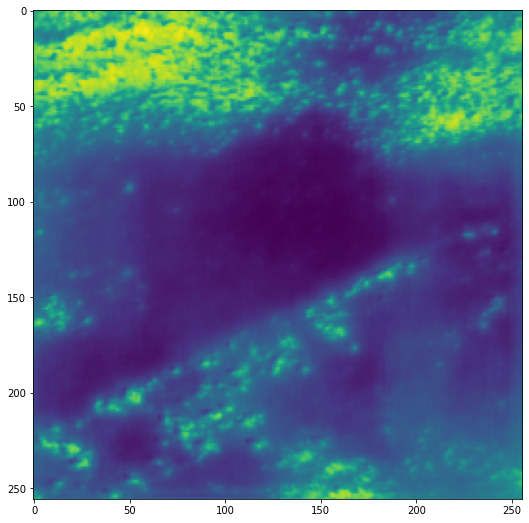

In [76]:
n = 0
img = sample_image[n]
img = img[np.newaxis, ...]
out = model(img)
print(out.shape)

plt.figure(figsize=(9, 9))
plt.imshow(img[0])
plt.show()
plt.figure(figsize=(9, 9))
plt.imshow(sample_mask[n])
plt.show()
plt.figure(figsize=(9, 9))
plt.imshow(out[0])
plt.show()


In [70]:
tf.keras.utils.plot_model(model)
model_history = model.fit(trainset_tf, epochs=50)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Epoch 1/50
68/68 [==============================] - 160s 2s/step - loss: 0.0166 - mae: 0.4612 - acc: 0.7750
Epoch 2/50
68/68 [==============================] - 159s 2s/step - loss: 0.0114 - mae: 0.4077 - acc: 0.8660
Epoch 3/50
68/68 [==============================] - 159s 2s/step - loss: 0.0109 - mae: 0.3902 - acc: 0.8718
Epoch 4/50
68/68 [==============================] - 162s 2s/step - loss: 0.0095 - mae: 0.3772 - acc: 0.8938
Epoch 5/50
68/68 [==============================] - 159s 2s/step - loss: 0.0088 - mae: 0.3589 - acc: 0.9016
Epoch 6/50
68/68 [==============================] - 159s 2s/step - loss: 0.0087 - mae: 0.3544 - acc: 0.9051
Epoch 7/50
68/68 [==============================] - 159s 2s/step - loss: 0.0087 - mae: 0.3611 - acc: 0.8992
Epoch 8/50
68/68 [==============================] - 159s 2s/step - loss: 0.0086 - 

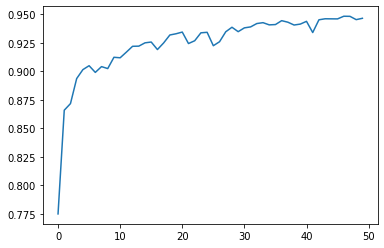

In [71]:
plt.plot(model_history.history['acc'])
plt.show()

In [30]:
# conver to a tflite model
# concrete_func = model.__call__.get_concrete_function()

# create a representative dataset

def representative_dataset():
    for data in tf.data.Dataset.from_tensor_slices((trainset.images_list)).map(lambda x: CloudDataset.load_img(x)[0]).batch(1).take(100):
        yield [tf.dtypes.cast(data, tf.float32)]
    

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.representative_dataset = representative_dataset
converter.inference_input_type = tf.uint8  # or tf.uint8
converter.inference_output_type = tf.uint8  # or tf.uint8tflite_model = converter.convert()

tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Shreeyam\AppData\Local\Temp\tmppoelrpkn\assets


c:\users\shreeyam\appdata\local\programs\python\python39\lib\site-packages\tensorflow\lite\python\convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [79]:
model.save_weights("cloud_model_g5_weights")